**AgriVoltaic Analysis Notebook**

This notebook seeks to model the symbiotic relationship between solar photovoltaic energy production systems and agricultural systems. 

The basic idea being that solar photovoltaic cells have an efficiency versus temperature curve similar to this: 

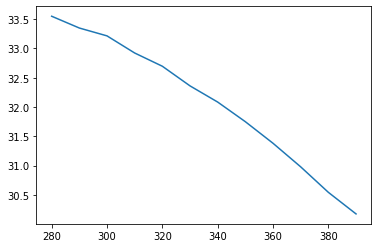

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# We will assume the panel has the efficiency vs. temperature plot as shown in the curve above:
T = np.array([280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0]) # Panel temperature in Kelvin
eta_data = np.array([33.548,	33.347,	33.213,	32.921,	32.695,	32.36,	32.084,	31.749,	31.381,	30.979,	30.544,	30.176]) # Panel efficiency
#Reference: http://synergyfiles.com/2017/01/effective_methods_for_cooling_pv-panels/ 

plt.plot(T,eta_data)
plt.xlabel='Temperature [Kelvin]'
plt.ylabel='eta'


And the symbiotic relationship being that plants transpire (similar to how humans sweat) as shown below:

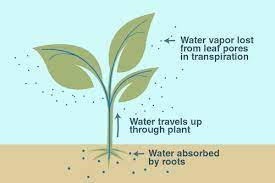




In the transpiration process, water vapor is lost from pores in the leafs. Thus the water evaporates, which effectively pulls heat out of the surrounding air or pulls heat out of solar panels that are adjacent to the plant. 

Starting off with a simple model of 1 panel and 1 plant:

In [31]:
# we will now do a curve fit of the data for future use:

import numpy as np

[a,b,c] = np.polyfit(T,eta_data,2)

def eta_fit(T):
  eta = a*T**2+b*T+c
  return(eta)

In [46]:

# We will assume that the plant transpires at a constant rate of 0.3mL/min: https://www.teachengineering.org/activities/view/usf_stormwater_lesson02_activity1
w_dot = 0.3 #mL/min
# or
w_dot = w_dot/1000/60 #L/second

# if you would like to see more about how transpiration rates may be measured,
# please see: https://www.youtube.com/watch?v=gPsncnQ5TPU&ab_channel=AlexLee


# We will assume that the sun's irradiance reaches a maximum of 1000 Watts on 
# the panel. Of this power:
# 10% is reflected,
# the efficeincy as defined by the curve above is converted to electricity,
# and the remaining power is absorbed as heat. 

# This gives us a curve describing the absorbed heat rate vs. temperature:
def Q_dot_in(solar_power,T):
  reflected = 0.1 #10%
  power_in = solar_power #sun's power input to the panel in Watts
  Q_dot_in = power_in*(1-reflected)*(100-eta_fit(T))/100 # Watts
  return(Q_dot_in) 

In [53]:
# From here, we need the latent heat of vaporization for water which is:
Q_dot_vap = 2260 #kJ/kg ~= kJ/L as the density of water is ~1kg/L

# The plant's transpiration will remove this much heat from the surroundings:
Q_dot_transpiration = w_dot/60*Q_dot_vap*1000 #L/sec*kJ/L*1000J/1kJ = J/sec = Watts
Q_dot_transpiration

0.18833333333333332

Text(0.5, 1.0, 'Power Incident on Solar Panel')

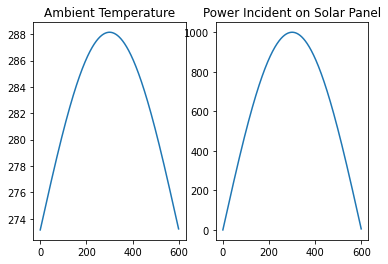

In [54]:
# Now we'll make a simple model of the ambient conditions for 10 hours of a day:
time = np.array(range(10*60))
T_amb = 15*np.sin(time*np.pi/len(time))+273.15 # ambient temperature in Kelvin
sun_power = 1000*np.sin(time*np.pi/len(time)) # sun's power incident on the panel

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(time,T_amb)
ax1.set_title('Ambient Temperature')
ax2.plot(time,sun_power)
ax2.set_title('Power Incident on Solar Panel')

In [55]:
# Next we'll assume that the panel only loses heat through radiative heat
# transfer to the environment:
def Q_rad_out(T_panel,T_sur):
  Stefan_Boltzmann = 5.67*10**-8 #Watts/(m^2*K^4)
  epsilon = 0.8 #assumed surface emmissivity
  area = 1 #m^2, assuming surface area of 1 square meter
  Q_rad_out = Stefan_Boltzmann*epsilon*area*(T_panel**4-T_sur**4)  # Watts
  return(Q_rad_out) 

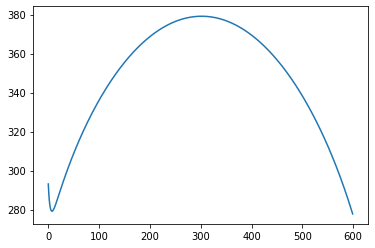

In [56]:
# Now we assume that the panel starts the day at a temperature of 20C (293.15K)
# when the sun rises and a thermal mass of 1000J/K. We now compare the heat 
# rates to see how the panel's temperature changes during the day:

T_init = 293.15 # Kelvin
panel_thermal_mass = 1000 #J/K

T_panel = np.zeros(len(time)) #initialize panel temperature array
T_panel[0] = T_init
for i in range(len(time)-1):
  Q_in = Q_dot_in(sun_power[i],T_panel[i]) #Watts in
  Q_out = Q_rad_out(T_panel[i],T_amb[i]) # Watts out
  dt = 60 #seconds
  panel_dT = (Q_in-Q_out)*dt/panel_thermal_mass # (J/s*s)/(J/K) = J*K/J = K, panel temperature increase
  T_panel[i+1]=T_panel[i]+panel_dT


plt.plot(time,T_panel)

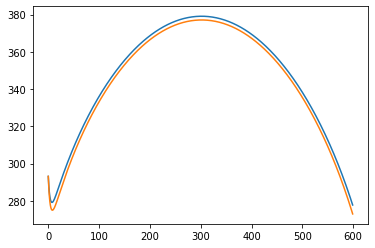

In [58]:
# We will now repeat the analysis except that we will assume that all of the 
# energy absorbed in the evaporation of water from the plant is removed from the
# solar panel

T_panel2 = np.zeros(len(time)) #initialize panel temperature array
T_panel2[0] = T_init
for i in range(len(time)-1):
  Q_in = Q_dot_in(sun_power[i],T_panel2[i]) #Watts in
  Q_out = Q_rad_out(T_panel2[i],T_amb[i]) # Watts out
  dt = 60 #seconds
  panel_dT = (Q_in-Q_out-Q_dot_transpiration*100)*dt/panel_thermal_mass # (J/s*s)/(J/K) = J*K/J = K, panel temperature increase
  T_panel2[i+1]=T_panel2[i]+panel_dT


plt.plot(time,T_panel,time,T_panel2)